In [2]:
import os
import re
import cv2
import yaml
import tqdm
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from backbone import EfficientDetBackbone
from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, boolean_string

In [3]:
params = yaml.safe_load(open(f'projects/coco.yml'))
obj_list = params['obj_list']

In [4]:
model = EfficientDetBackbone(compound_coef=0, num_classes=len(obj_list),
                            ratios=eval(params['anchors_ratios']), scales=eval(params['anchors_scales']))
model.load_state_dict(torch.load('weights/efficientdet-d0.pth', map_location=torch.device('cpu')))
model.requires_grad_(False)
model.eval()

EfficientDetBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
      

In [5]:
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
threshold=0.05
nms_threshold=0.5

In [6]:
kitti_image_dir = '/data/kitti/object2D/training/image_2/'

In [7]:
kitti_label_path = '/data/kitti/object2D/training/label_2'

In [8]:
def ED_detect_image(image_num):
    
    file_path = os.path.join(kitti_image_dir, image_num) + '.png'
    #print(f'Detecting on image: {file_path}')
    # XXX: research what the preprocessing does
    ori_imgs, framed_imgs, framed_metas = preprocess(file_path, max_size=input_sizes[0])
    
    # convert the framed image into a tensor
    I = torch.from_numpy(framed_imgs[0])
    I = I.float()
    I = I.unsqueeze(0).permute(0, 3, 1, 2)
    
    # run it through the pre-trained model
    # XXX: research what the output fields are
    features, regression, classification, anchors = model(I)

    # XXX: what do these do?
    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    # XXX: dig into the postprocessing done
    preds = postprocess(I, anchors, regression, classification,
                    regressBoxes, clipBoxes,
                    threshold, nms_threshold)
    
    # XXX: ???
    preds = invert_affine(framed_metas, preds)[0] 
    
    scores = preds['scores']
    class_ids = preds['class_ids']
    rois = preds['rois']
    
    results = []
    if rois.shape[0] > 0:
        # x1,y1,x2,y2 -> x1,y1,w,h
        #rois[:, 2] -= rois[:, 0]
        #rois[:, 3] -= rois[:, 1]

        bbox_score = scores

        for roi_id in range(rois.shape[0]):
            score = float(bbox_score[roi_id])
            label = int(class_ids[roi_id])
            box = rois[roi_id, :]

            image_result = {
                'category_id': label + 1,
                'score': float(score),
                'bbox': box.tolist(),
            }

            results.append(image_result)
        
    return results, ori_imgs[0]

In [9]:
results, ori_image = ED_detect_image('000000')

In [10]:
results

[{'category_id': 1,
  'score': 0.8647946119308472,
  'bbox': [712.3680419921875,
   148.7045440673828,
   804.7902221679688,
   304.6386413574219]},
 {'category_id': 64,
  'score': 0.4024623930454254,
  'bbox': [494.7999572753906,
   172.3993377685547,
   555.0234375,
   249.54168701171875]},
 {'category_id': 1,
  'score': 0.3795817196369171,
  'bbox': [829.1907958984375,
   161.76329040527344,
   870.4699096679688,
   256.4312438964844]},
 {'category_id': 2,
  'score': 0.25196000933647156,
  'bbox': [905.301025390625,
   208.63417053222656,
   958.786865234375,
   278.1383972167969]},
 {'category_id': 2,
  'score': 0.2429163008928299,
  'bbox': [881.4802856445312,
   207.6787872314453,
   934.1441040039062,
   277.8922424316406]},
 {'category_id': 2,
  'score': 0.22012904286384583,
  'bbox': [879.6322631835938,
   211.93589782714844,
   910.2638549804688,
   279.6269226074219]},
 {'category_id': 2,
  'score': 0.21780367195606232,
  'bbox': [942.5184936523438,
   204.0518798828125,
   

In [11]:
def read_img_info(image_num):
    labels = []
    bbox = []
    file_path = os.path.join(kitti_label_path, image_num) + '.txt'
    with open(file_path) as f:
        for line in f:
            items = line.split()
            label = items[0]
            if label == 'DontCare':
                break
            labels.append(label)
            bbox.append([float(x) for x in items[4:8]])
    return labels, np.stack(bbox, axis=0)

In [12]:
read_img_info('004066')

(['Car', 'Car', 'Car', 'Car', 'Car', 'Car'],
 array([[   0.  ,  191.89,  139.78,  280.51],
        [ 639.13,  177.56,  678.25,  211.96],
        [ 592.75,  171.19,  633.53,  203.49],
        [ 658.04,  171.57,  688.6 ,  200.06],
        [ 940.23,  155.93, 1043.71,  191.18],
        [ 903.95,  155.93,  993.44,  189.35]]))

In [13]:
def check_image(image_num):
    results, ori_image = ED_detect_image(image_num)
    print(f'Detecting in {image_num}: ', end='')
    labels, boxes = read_img_info(image_num)
    print(f'{len(labels)} labels present - {labels}')
    img = np.float32(ori_image)
    for i in range(len(labels)):
        box = boxes[i]
        x,y,x2,y2 = box.astype(np.int)
        w = x2-x
        h = y2-y
        img = cv2.rectangle(img, (x,y), (x2, y2), (0,255,0), 8) 
        img = cv2.putText(img, str(i), (x+w//2, y+h//2),
                          cv2.FONT_HERSHEY_SIMPLEX,
                         fontScale=1,
                         color=(0,255,0),
                         thickness=6)
        plt.imshow(img.astype(np.int))
    plt.show()
    print("Going over the model detections...")
    img = np.float32(ori_image)
    for i in range(len(labels)):
        try:
            bbox = results[i]['bbox']
            x,y,x2,y2 = np.array(bbox).astype(np.int)
            img = cv2.rectangle(img, (x,y), (x2, y2), (0,255,0), 8)
            plt.imshow(img.astype(np.int))
        except:
            print('No bounding box found')
    plt.show()

Detecting in 004066: 6 labels present - ['Car', 'Car', 'Car', 'Car', 'Car', 'Car']


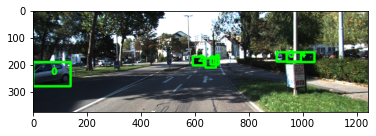

Going over the model detections...


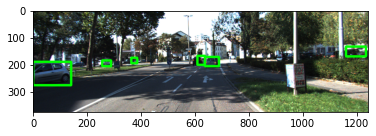

In [14]:
check_image('004066')

Detecting in 000000: 1 labels present - ['Pedestrian']


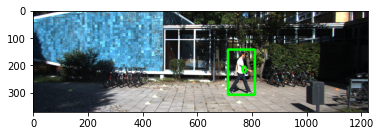

Going over the model detections...


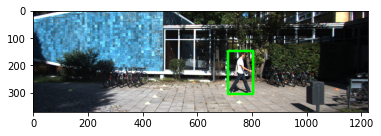

Detecting in 000001: 3 labels present - ['Truck', 'Car', 'Cyclist']


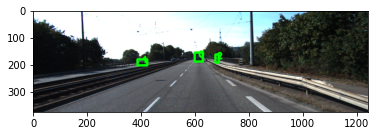

Going over the model detections...


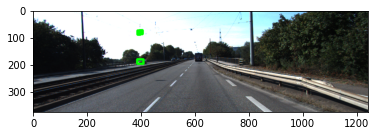

Detecting in 000002: 2 labels present - ['Misc', 'Car']


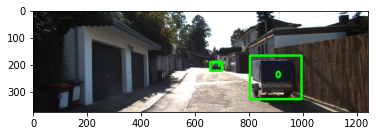

Going over the model detections...


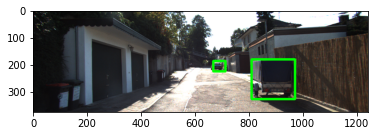

Detecting in 000003: 1 labels present - ['Car']


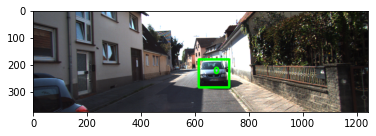

Going over the model detections...


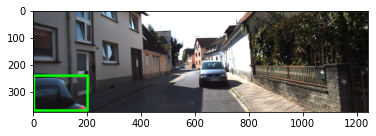

Detecting in 000004: 2 labels present - ['Car', 'Car']


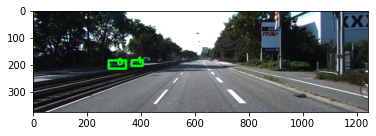

Going over the model detections...


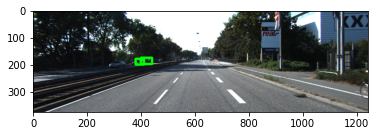

Detecting in 000005: 1 labels present - ['Pedestrian']


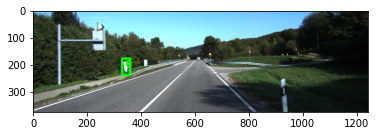

Going over the model detections...


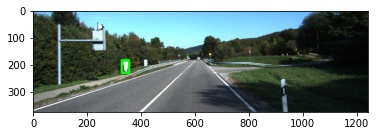

In [15]:
image_list = ['000000','000001','000002','000003','000004','000005']
for i in image_list:
    check_image(i)

In [16]:
def area(boxes, add1=False):
    """Computes area of boxes.
    Args:
        boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
        a numpy array with shape [N*1] representing box areas
    """
    if add1:
        return (boxes[:, 2] - boxes[:, 0] + 1.0) * (
            boxes[:, 3] - boxes[:, 1] + 1.0)
    else:
        return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])


def intersection(boxes1, boxes2, add1=False):
    """Compute pairwise intersection areas between boxes.
    Args:
        boxes1: a numpy array with shape [N, 4] holding N boxes
        boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
        a numpy array with shape [N*M] representing pairwise intersection area
    """
    [y_min1, x_min1, y_max1, x_max1] = np.split(boxes1, 4, axis=1)
    [y_min2, x_min2, y_max2, x_max2] = np.split(boxes2, 4, axis=1)

    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    if add1:
        all_pairs_min_ymax += 1.0
    intersect_heights = np.maximum(
        np.zeros(all_pairs_max_ymin.shape),
        all_pairs_min_ymax - all_pairs_max_ymin)

    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    if add1:
        all_pairs_min_xmax += 1.0
    intersect_widths = np.maximum(
        np.zeros(all_pairs_max_xmin.shape),
        all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths


def iou(boxes1, boxes2, add1=False):
    """Computes pairwise intersection-over-union between box collections.
    Args:
        boxes1: a numpy array with shape [N, 4] holding N boxes.
        boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
        a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2, add1)
    area1 = area(boxes1, add1)
    area2 = area(boxes2, add1)
    union = np.expand_dims(
        area1, axis=1) + np.expand_dims(
            area2, axis=0) - intersect
    return intersect / union

In [25]:
def get_label_anno(label_path):
    annotations = {}
    annotations.update({
        'name': [],
        'truncated': [],
        'occluded': [],
        'alpha': [],
        'bbox': [],
        'dimensions': [],
        'location': [],
        'rotation_y': []
    })
    lines = []
    with open(label_path, 'r') as f:
        for l in f:
            items = l.strip().split(' ')
            if items[0] == 'DontCare':
                continue
            lines.append(l)
    # if len(lines) == 0 or len(lines[0]) < 15:
    #     content = []
    # else:
    content = [line.strip().split(' ') for line in lines]
    #print(f'{content[0]}')
    annotations['name'] = np.array([x[0] for x in content])
    annotations['truncated'] = np.array([float(x[1]) for x in content])
    annotations['occluded'] = np.array([int(x[2]) for x in content])
    annotations['alpha'] = np.array([float(x[3]) for x in content])
    annotations['bbox'] = np.array(
        [[float(info) for info in x[4:8]] for x in content]).reshape(-1, 4)
    # dimensions will convert hwl format to standard lhw(camera) format.
    annotations['dimensions'] = np.array(
        [[float(info) for info in x[8:11]] for x in content]).reshape(
            -1, 3)[:, [2, 0, 1]]
    annotations['location'] = np.array(
        [[float(info) for info in x[11:14]] for x in content]).reshape(-1, 3)
    annotations['rotation_y'] = np.array(
        [float(x[14]) for x in content]).reshape(-1)
    if len(content) != 0 and len(content[0]) == 16:  # have score
        annotations['score'] = np.array([float(x[15]) for x in content])
    else:
        annotations['score'] = np.zeros([len(annotations['bbox'])])
    return annotations

In [26]:
def get_image_index_str(img_idx):
    return "{:06d}".format(img_idx)

def get_label_annos(label_folder, image_ids=None):
    if image_ids is None:
        filepaths = pathlib.Path(label_folder).glob('*.txt')
        prog = re.compile(r'^\d{6}.txt$')
        filepaths = filter(lambda f: prog.match(f.name), filepaths)
        image_ids = [int(p.stem) for p in filepaths]
        image_ids = sorted(image_ids)
    if not isinstance(image_ids, list):
        image_ids = list(range(image_ids))
    annos = []
    label_folder = pathlib.Path(label_folder)
    for idx in image_ids:
        image_idx = get_image_index_str(idx)
        label_filename = label_folder / (image_idx + '.txt')
        annos.append(get_label_anno(label_filename))
    return annos

In [27]:
label_annos = get_label_annos(kitti_label_path)

In [28]:
label_annos[44]

{'name': array(['Car', 'Car'], dtype='<U3'),
 'truncated': array([0.7, 0. ]),
 'occluded': array([0, 0]),
 'alpha': array([2.11, 1.79]),
 'bbox': array([[  0.  , 203.44, 365.5 , 374.  ],
        [378.01, 183.98, 507.17, 276.44]]),
 'dimensions': array([[3.67, 1.44, 1.62],
        [3.68, 1.51, 1.62]]),
 'location': array([[-3.27,  1.73,  5.22],
        [-3.11,  1.75, 13.93]]),
 'rotation_y': array([1.58, 1.57]),
 'score': array([0., 0.])}

In [29]:
total_samples=len(label_annos)
total_samples

7481

In [222]:
def evalaute_prediction(image_num):
    # get the labels
    bbox1 = label_annos[image_num]['bbox']
    # next get the model's results
    results, _ = ED_detect_image(get_image_index_str(image_num))
    # pick the number of results present in the label
    bbox2 = np.stack([results[i]['bbox'] for i in range(bbox1.shape[0])])
    # get the iou information (NxN matrix)
    r = iou(bbox1, bbox2)
    # pick the best result from each row
    res = [np.max(r[i]) for i in range(r.shape[0])]
    # return just the first result for now
    return res[0]

In [223]:
evalaute_prediction(0)

0.8881254161649861

In [146]:
%%time
top_IoUs = []
for i in tqdm.notebook.tqdm(range(total_samples)):
    x = evalaute_prediction(i)
    top_IoUs.append(x)


CPU times: user 2h 57min 31s, sys: 5min 49s, total: 3h 3min 21s
Wall time: 28min 28s


In [148]:
top_IoUs = np.array(top_IoUs)

(array([ 771.,   65.,   63.,   81.,   85.,  106.,  137.,  166.,  215.,
         242.,  246.,  263.,  261.,  322.,  397.,  630.,  908., 1310.,
        1025.,  188.]),
 array([0.        , 0.04925184, 0.09850369, 0.14775553, 0.19700737,
        0.24625922, 0.29551106, 0.3447629 , 0.39401475, 0.44326659,
        0.49251843, 0.54177028, 0.59102212, 0.64027396, 0.6895258 ,
        0.73877765, 0.78802949, 0.83728133, 0.88653318, 0.93578502,
        0.98503686]),
 <BarContainer object of 20 artists>)

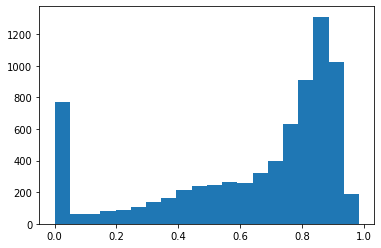

In [151]:
# plot the top image IoU histogram
plt.hist(top_IoUs, bins=20)

## Build Regression Model for Distance

In [30]:
def regression_data(image_num):
    # get the labels
    bbox1 = label_annos[image_num]['bbox']
    # compute the height and width of the object
    bbox1[:, 2] -= bbox1[:, 0]
    bbox1[:, 3] -= bbox1[:, 1]
    # compute the distance provided
    loc = label_annos[image_num]['location']
    d = np.sqrt(loc[:,0]**2 + loc[:,2]**2)
    return bbox1[:,2:], d

In [31]:
%%time
y = np.zeros(1)
X = np.zeros(2).reshape(-1,2)
for i in tqdm.notebook.tqdm(range(total_samples)):
    x, l = regression_data(i)
    X = np.concatenate((X, x), axis=0)
    y = np.concatenate((y, l), axis=0)


CPU times: user 849 ms, sys: 7.05 ms, total: 857 ms
Wall time: 850 ms


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
regr = RandomForestRegressor(n_estimators=100, random_state=42)

In [35]:
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
y_pred = regr.predict(X_test)

In [39]:
np.sqrt(mean_squared_error(y_test, y_pred))

6.7780544941849215

In [38]:
y_test[:10], y_pred[:10]

(array([28.05421181, 15.60314071, 61.43287231, 56.55688199,  4.54805453,
        24.12316729, 31.04205696, 25.38636248, 39.00930786, 23.93651813]),
 array([34.13570924, 15.34802309, 58.8058147 , 33.84602662,  8.06397432,
        23.98011643, 31.41199553, 26.70483345, 25.27650722, 22.9531441 ]))